In [1]:
import numpy as np
import datetime as dt 
import pandas as pd
import pandas_datareader.data as web
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from arch import arch_model
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# Set date ranges:
# Start date
start = dt.datetime(2018,1,1)
# End date
end = dt.datetime(2020,6,30)

# Set symbol name
symbol_name = 'SP500'

In [3]:
# Dictionary of stock names & their corresponding symbols
symbols = {
    'SP500': '^GSPC',
    'Russell2000': '^RUT',
    'Apple': 'APPL',
    'Microsoft': 'MSFT'
}

# Import data using Pandas Datareader
df = web.DataReader(
        name = symbols[symbol_name], data_source = 'yahoo', 
        start = start, end = end
    )

# Print prices of selected stock for start and end date
print(pd.concat([df.head(1), df.tail(1)]))

High          Low         Open        Close      Volume  \
Date                                                                         
2018-01-02  2695.889893  2682.360107  2683.729980  2695.810059  3367250000   
2020-06-30  3111.510010  3047.830078  3050.199951  3100.290039  4696280000   

              Adj Close  
Date                     
2018-01-02  2695.810059  
2020-06-30  3100.290039  


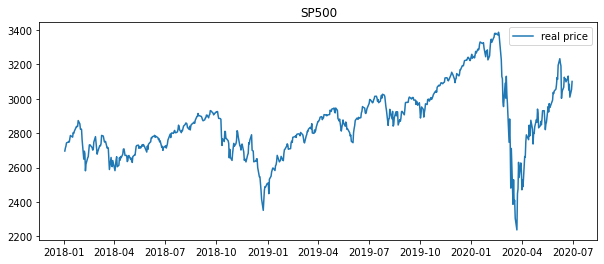

In [4]:
# Plot historical price data
plt.figure(figsize=(10,4))
plt.title(symbol_name)
plt.plot(df['Close'], label='real price')
plt.legend()
plt.show()

Train: 439, Test: 189


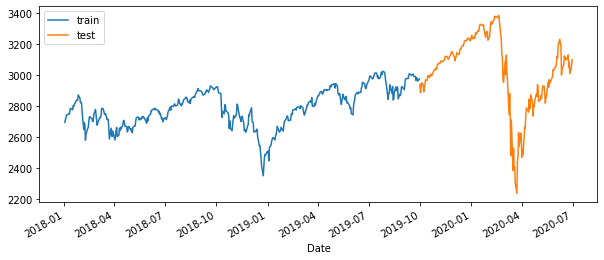

In [5]:
# Train test split
def train_test_split(X, size=0.7):
    train = X[:int(X.shape[0]*size)]
    test = X[int(X.shape[0]*size):]
    return train, test

train, test = train_test_split(X=df['Close'], size=0.7)
print(f'Train: {len(train)}, Test: {len(test)}')

# Plot train & test datasets
fig, ax = plt.subplots(figsize=(10,4))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
ax.legend()
plt.show()